In [ ]:
#Written by z5222191 for COMP9517 Assignment 2

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
%matplotlib inline

In [22]:
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [5]:
train_positive = []
#Reading all the images from train_positive_A
for i in range(8):
    path_name = 'train/train_positive_A/0000000' + str(i)
    #print(path_name)
    entries = Path(path_name)
    for entry in sorted(entries.iterdir()):
        img = cv2.imread(str(entry))
        train_positive.append(img)

In [6]:
#Reading all the images from train_positive_B
for i in range(7):
    path_name = 'train/train_positive_B/0000000' + str(i)
    #print(path_name)
    entries = Path(path_name)
    for entry in sorted(entries.iterdir()):
        img = cv2.imread(str(entry))
        train_positive.append(img)

In [7]:
#Reading all the images from train_positive_C
for i in range(8):
    path_name = 'train/train_positive_C/0000000' + str(i)
    #print(path_name)
    entries = Path(path_name)
    for entry in sorted(entries.iterdir()):
        img = cv2.imread(str(entry))
        train_positive.append(img)

In [8]:
len(train_positive)

22114

In [9]:
#Similarly we create a list called train_negative
train_negative = []
for i in range(10):
    path_name = 'train/train_negative_A/0000000' + str(i)
    #print(path_name)
    entries = Path(path_name)
    for entry in sorted(entries.iterdir()):
        img = cv2.imread(str(entry))
        train_negative.append(img)

In [10]:
len(train_negative)

10000

In [11]:
positive_batch = train_positive[:5000]
negative_batch = train_negative[:5000]
positive_labels = [1] * 5000
negative_labels = [0] * 5000

In [12]:
image_shape = positive_batch[0].shape
image_shape

(80, 64, 3)

In [13]:
for i in range(5000):
    positive_batch[i] = positive_batch[i].flatten()
    negative_batch[i] = negative_batch[i].flatten()

In [14]:
positive = pd.DataFrame(list(zip(positive_batch, positive_labels)), columns =['Image', 'Label'])
negative = pd.DataFrame(list(zip(negative_batch, negative_labels)), columns =['Image', 'Label'])

In [15]:
data = pd.concat([positive, negative], ignore_index=True)

In [16]:
data

,Image,Label
0,"[85, 126, 102, 138, 156, 132, 41, 67, 40, 84, ...",1
1,"[45, 43, 43, 50, 43, 42, 50, 46, 41, 48, 46, 4...",1
2,"[13, 13, 46, 20, 20, 28, 44, 44, 48, 85, 87, 9...",1
3,"[249, 245, 241, 255, 251, 248, 244, 240, 243, ...",1
4,"[31, 38, 22, 31, 32, 20, 30, 33, 24, 29, 33, 2...",1
...,...,...
9995,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",0
9996,"[159, 163, 164, 169, 168, 175, 178, 156, 165, ...",0
9997,"[168, 160, 143, 159, 148, 135, 157, 145, 136, ...",0
9998,"[225, 216, 202, 225, 216, 202, 225, 216, 202, ...",0


In [17]:
SIFT_features = []
for i in range(len(data['Image'])):
    temp = data['Image'][i]
    #print(temp.shape)
    temp = temp.reshape(80,64,3)
    gray = cv2.cvtColor(temp,cv2.COLOR_RGB2GRAY)
    #print(temp.size)
    #print(temp.shape)
    SIFT = cv2.xfeatures2d.SIFT_create()
    key_points,descriptors = SIFT.detectAndCompute(gray,None)
    #print(descriptors)
    #print(descriptors.shape)
    if descriptors is not None:
        descriptors = descriptors.flatten()
        #print(descriptors.shape)
        minimum_size = temp.size//10
        if descriptors.size < minimum_size:
            descriptors = np.concatenate([descriptors, np.zeros(minimum_size - descriptors.size)])
        elif descriptors.size > minimum_size:
            descriptors = descriptors[:minimum_size]
    else:
        descriptors = np.zeros(minimum_size)
    #print(descriptors.shape)
    SIFT_features.append(descriptors)

In [18]:
#Adding the SIFT features to the Dataframe created
data['SIFT features'] = SIFT_features

In [19]:
data.head()

,Image,Label,SIFT features
0,"[85, 126, 102, 138, 156, 132, 41, 67, 40, 84, ...",1,"[0.0, 0.0, 5.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,"[45, 43, 43, 50, 43, 42, 50, 46, 41, 48, 46, 4...",1,"[1.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0,..."
2,"[13, 13, 46, 20, 20, 28, 44, 44, 48, 85, 87, 9...",1,"[51.0, 17.0, 4.0, 25.0, 43.0, 2.0, 0.0, 0.0, 1..."
3,"[249, 245, 241, 255, 251, 248, 244, 240, 243, ...",1,"[24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 44.0, 176..."
4,"[31, 38, 22, 31, 32, 20, 30, 33, 24, 29, 33, 2...",1,"[142.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 86.0, 14..."


In [20]:
data = shuffle(data)

In [24]:
KNN_Scores = []
features = ['SIFT features']
for feature in features:
    x = np.array(data[feature])
    y = np.array(data['Label'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=6)
    x_train_len = len(x_train)
    x_train_shape = len(x_train[0])
    x_test_len = len(x_test)
    x_test_shape = len(x_test[0])
    #print(x_train_shape,x_train_len)
    temp1 = []
    for i in range(len(x_train)):
        for x in x_train[i]:
            temp1.append(x)
    x_train = np.array(temp1).reshape(x_train_len,x_train_shape)
    temp2 = []
    for i in range(len(x_test)):
        for x in x_test[i]:
            temp2.append(x)
    x_test = np.array(temp2).reshape(x_test_len,x_test_shape)
    knn = KNeighborsClassifier(n_neighbors=5)
    #svc = SVC(kernel='rbf', gamma=0.00001, C=1000,probability=True)
    knn.fit(x_train, y_train)
    knn_predict = knn.predict(x_test)
    knn_accuracy_score = metrics.accuracy_score(y_test,knn_predict)
    knn_recall_score=metrics.recall_score(y_test, knn_predict, average='macro')
    confusion_matrix=metrics.confusion_matrix(y_test, knn_predict)
    average_precision = metrics.average_precision_score(y_test, knn_predict)
    print(f'KNN Accuracy for {feature} : {knn_accuracy_score:0.3f}\n')
    print(f'KNN Recall for {feature} : {knn_recall_score:0.3f}\n')
    print(f'KNN Precision for {feature} : {average_precision:0.3f}\n')
    print(f'Confusion Matrix\n')
    print(confusion_matrix)
    fp_rate, tp_rate, thresholds = roc_curve(y_test, knn_predict)
    KNN_Scores.append((fp_rate,tp_rate,auc(fp_rate, tp_rate)))
    print('\n')

KNN Accuracy for SIFT features : 0.620

KNN Recall for SIFT features : 0.621

KNN Precision for SIFT features : 0.605

Confusion Matrix

[[1175   68]
 [ 883  374]]




In [25]:
SVC_Scores = []
features = ['SIFT features']
for feature in features:
    x = np.array(data[feature])
    y = np.array(data['Label'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=6)
    x_train_len = len(x_train)
    x_train_shape = len(x_train[0])
    x_test_len = len(x_test)
    x_test_shape = len(x_test[0])
    #print(x_train_shape,x_train_len)
    temp1 = []
    for i in range(len(x_train)):
        for x in x_train[i]:
            temp1.append(x)
    x_train = np.array(temp1).reshape(x_train_len,x_train_shape)
    temp2 = []
    for i in range(len(x_test)):
        for x in x_test[i]:
            temp2.append(x)
    x_test = np.array(temp2).reshape(x_test_len,x_test_shape)
    svc = LinearSVC(dual=False)
    #svc = SVC(kernel='rbf', gamma=0.00001, C=1000,probability=True)
    svc.fit(x_train, y_train)
    svc_predict = svc.predict(x_test)
    svc_accuracy_score = metrics.accuracy_score(y_test,svc_predict)
    svc_recall_score=metrics.recall_score(y_test, svc_predict, average='macro')
    confusion_matrix=metrics.confusion_matrix(y_test, svc_predict)
    average_precision = metrics.average_precision_score(y_test, svc_predict)
    #test.append(metrics.roc_auc_score(y_test, svc.predict(x_test)))
    print(f'SVC Accuracy for {feature} : {svc_accuracy_score:0.3f}\n')
    print(f'SVC Recall for {feature} : {svc_recall_score:0.3f}\n')
    print(f'SVC Precision for {feature} : {average_precision:0.3f}\n')
    print(f'Confusion Matrix\n')
    print(confusion_matrix)
    fp_rate, tp_rate, thresholds = roc_curve(y_test, svc_predict)
    SVC_Scores.append((fp_rate,tp_rate,auc(fp_rate, tp_rate)))
    print('\n')

SVC Accuracy for SIFT features : 0.754

SVC Recall for SIFT features : 0.754

SVC Precision for SIFT features : 0.693

Confusion Matrix

[[930 313]
 [301 956]]




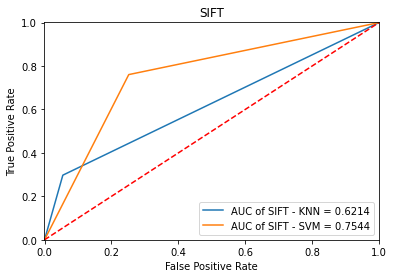

In [27]:
plt.title('SIFT')
plt.plot(KNN_Scores[0][0], KNN_Scores[0][1], label='AUC of SIFT - KNN = %0.4f'% KNN_Scores[0][2])
plt.plot(SVC_Scores[0][0], SVC_Scores[0][1], label='AUC of SIFT - SVM = %0.4f'% SVC_Scores[0][2])
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
#data.to_csv("Features2.csv")

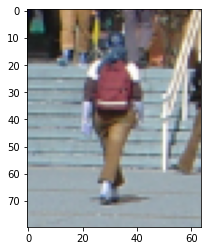

In [29]:
#Example of Feature Extraction of SIFT
example = cv2.imread('train/train_positive_A/00000000/item_00000002.pnm')
plt.imshow(example)

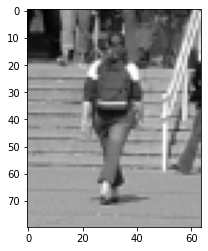

In [32]:
gray_img = cv2.cvtColor(example,cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img,cmap='gray')

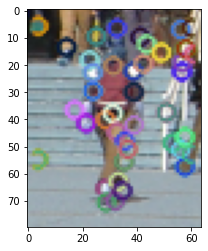

In [36]:
#Visualising SIFT feature extraction on images
SIFT = cv2.xfeatures2d.SIFT_create()
key_points,descriptors = SIFT.detectAndCompute(gray_img,None)
cv2.drawKeypoints(example,key_points,example)
plt.imshow(example,cmap='gray')